In [27]:
import os
import tempfile
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


from ultralytics import YOLOv10

In [ ]:
img_path = os.path.join(os.getcwd(), "test.jpg")
model_path = os.path.join(os.getcwd(), "ckpts", "YOLO", "YOLOv10", "YOLOv10", "weights", "best.pt")

model = YOLOv10(model_path)
results = model(img_path)

#* WE FIX THE SIZE OF THE EYE CROPPED IMAGE TO 160x120 AS A FORTH OF THE ACTUAL
#* IMAGE SIZE OF A 640x480 IMAGE (SIZE OF IRIS-THOUSAND DATASET)
#* AFTER THE YOLO DETECTION, WE TAKE THE CENTER OF THE BOUNDING BOX AND 
#* INCREASE THE SIZE OF THE BOX TO 160x120 AND CROP THE IMAGE
SIZE_W = 160
SIZE_H = 120

boxes = results[0].boxes.xyxy.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy()

img = Image.open(img_path)
face_boxes = boxes[classes == 0]
eye_boxes = boxes[classes == 1]


image 1/1 /home/cati/Desktop/Dev/NotThatIris-Detector/test.jpg: 448x640 1 FACE, 2 EYEs, 12.7ms
Speed: 1.5ms preprocess, 12.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


In [29]:
faces = {id: bbox for id, bbox in enumerate(face_boxes)}

eyes = {}
for eye_box in eye_boxes:
    for id, face in faces.items():
        if (eye_box[0] > face[0]) and (eye_box[1] > face[1]) and (eye_box[2] < face[2]) and (eye_box[3] < face[3]):
            eyes[id] = eyes.get(id, []) + [eye_box]
eyes

{0: [array([     588.09,      394.97,      658.73,      424.11], dtype=float32),
  array([     803.95,      401.63,      879.11,      432.64], dtype=float32)]}

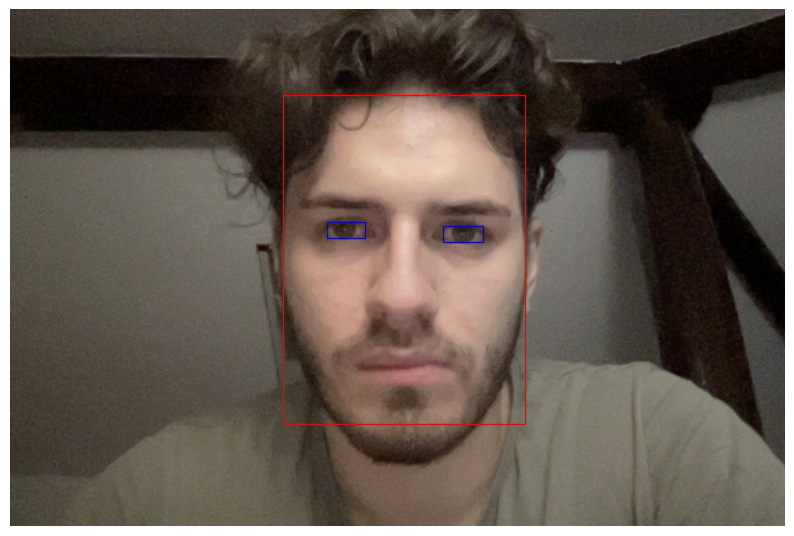

In [30]:
plt.figure(figsize=(10, 10))

for id, face in faces.items():
    plt.gca().add_patch(plt.Rectangle((face[0], face[1]), face[2] - face[0], face[3] - face[1], fill=False, edgecolor="r", lw=1))
    for eye in eyes.get(id, []):
        plt.gca().add_patch(plt.Rectangle((eye[0], eye[1]), eye[2] - eye[0], eye[3] - eye[1], fill=False, edgecolor="b", lw=1))

plt.axis("off")
plt.imshow(img)

In [31]:
# CONVERT EYE BBOXES TO 160x120

for id, face in faces.items():
    face_img = img.crop(face)
    face_img = face_img.resize((SIZE_W, SIZE_H))
    face_img.save(f"face_{id}.jpg")

    for i, eye in enumerate(eyes.get(id, [])):
        eye_center = [(eye[0] + eye[2]) / 2, (eye[1] + eye[3]) / 2]
        new_bbox = [eye_center[0] - SIZE_W // 2, eye_center[1] - SIZE_H // 2, eye_center[0] + SIZE_W // 2, eye_center[1] + SIZE_H // 2]
        eyes[id][i] = new_bbox

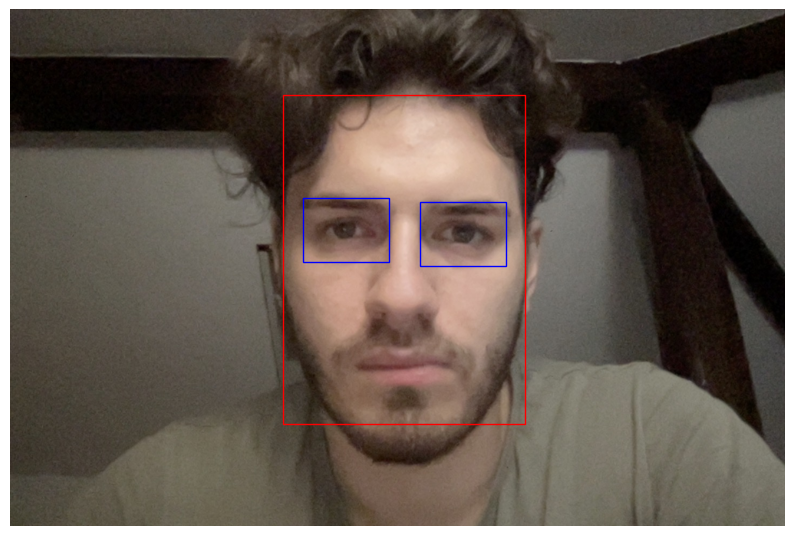

In [32]:
plt.figure(figsize=(10, 10))

for id, face in faces.items():
    plt.gca().add_patch(plt.Rectangle((face[0], face[1]), face[2] - face[0], face[3] - face[1], fill=False, edgecolor="r", lw=1))
    for eye in eyes.get(id, []):
        plt.gca().add_patch(plt.Rectangle((eye[0], eye[1]), eye[2] - eye[0], eye[3] - eye[1], fill=False, edgecolor="b", lw=1))

plt.axis("off")
plt.imshow(img)

In [33]:
dirs = []
for face in faces:
    print(f"Face {face}: {faces[face]}")
    tmpdir = tempfile.mkdtemp()
    dirs.append(tmpdir)
    for idx, eye in enumerate(eyes.get(face, [])):
        cropped = img.crop((eye[0], eye[1], eye[2], eye[3]))
        # cropped = cropped.convert("L")
        cropped.save(os.path.join(tmpdir, f"face_{face}_eye_{idx}.jpg"))

Face 0: [     506.75      159.44      955.88      770.11]


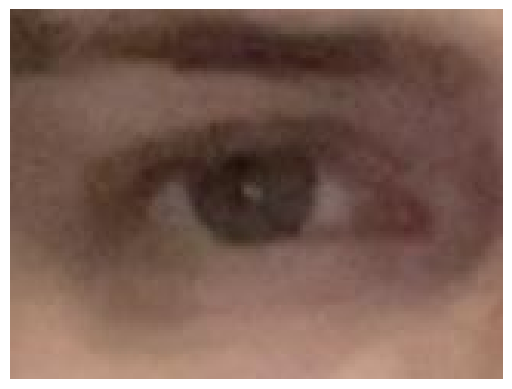

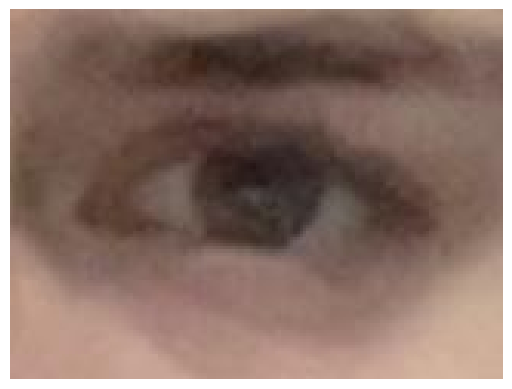

In [34]:
for dir in dirs:
    for file in os.listdir(dir):
        im = Image.open(os.path.join(dir, file))
        im.save("eye.jpg")
        plt.imshow(Image.open(os.path.join(dir, file)).convert("RGB"))
        plt.axis("off")
        plt.show()

Image face_0_eye_0.jpg: height=120, width=160
Width factor: 2, Height factor: 1
Resizing to height=120, width=320


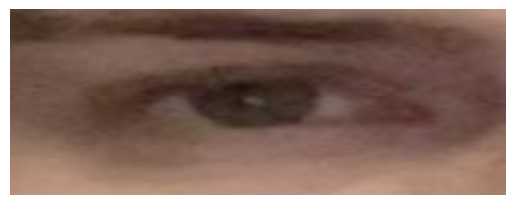

In [35]:
H = 180
W = 460

for dir in dirs:
    for file in os.listdir(dir):
        img = Image.open(os.path.join(dir, file))
        img = np.array(img)
        height, width, _ = img.shape
        print(f"Image {file}: height={height}, width={width}")

        w_factor = W // width
        h_factor = H // height
        print(f"Width factor: {w_factor}, Height factor: {h_factor}")

        new_h, new_w = height * h_factor, width * w_factor
        print(f"Resizing to height={new_h}, width={new_w}")

        img = Image.fromarray(img).resize((new_w, new_h), Image.BILINEAR).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        break